In [1]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_pulse_single_nu(
    t,
    nu_ghz,
    dt_dm=0.0,
    sigma_dm=0.3e-3,
    tau_1ghz=2.0e-3,
    alpha=4.0,
    t0=0.0
):
    dt = t[1] - t[0]
    G = (1.0 / (np.sqrt(2.0 * np.pi) * sigma_dm)) * np.exp(
        -0.5 * ((t - dt_dm) / sigma_dm) ** 2
    )
    tau_nu = tau_1ghz * nu_ghz**(-alpha)
    H = (t >= t0).astype(float)
    E = H * np.exp(-(t - t0) / tau_nu)
    return np.convolve(G, E, mode="same") * dt

# Time and frequency grids
t_min, t_max, dt = -5e-3, 8e-3, 2e-5
t = np.arange(t_min, t_max, dt)
nus = np.linspace(0.8, 1.6, 32)

# DM configuration
DM_true = 1000.0
DM_trial = 200.0
k_dm = 4.148808e3
nu_ref = 1.4

def dt_dm(DM, nu_ghz):
    nu_mhz = nu_ghz * 1e3
    nu_ref_mhz = nu_ref * 1e3
    delay_ms = k_dm * DM * (nu_mhz**-2 - nu_ref_mhz**-2)
    return delay_ms * 1e-3


In [2]:
# Generate observed data
dynamic_true = np.array([
    simulate_pulse_single_nu(t, nu, dt_dm=dt_dm(DM_true, nu))
    for nu in nus
])

# Dedisperse
dynamic_dedisp_true = np.zeros_like(dynamic_true)
dynamic_dedisp_trial = np.zeros_like(dynamic_true)

for i, nu in enumerate(nus):
    prof = dynamic_true[i]
    dynamic_dedisp_true[i] = np.interp(t + dt_dm(DM_true, nu), t, prof, left=0, right=0)
    dynamic_dedisp_trial[i] = np.interp(t + dt_dm(DM_trial, nu), t, prof, left=0, right=0)

# Log-log transform of underestimated DM
t_ms = t * 1e3
x = t_ms - t_ms.min() + 1e-6
y = nus

u = np.linspace(np.log(x.min()), np.log(x.max()), x.size)
v = np.linspace(np.log(y.min()), np.log(y.max()), y.size)

U, V = np.meshgrid(u, v)
Xn, Yn = np.exp(U), np.exp(V)

dx = x[1] - x[0]
dy = y[1] - y[0]

ix = np.clip((Xn - x.min()) / dx, 0, x.size - 1.001)
iy = np.clip((Yn - y.min()) / dy, 0, y.size - 1.001)

i0 = np.floor(ix).astype(int)
j0 = np.floor(iy).astype(int)
i1 = np.clip(i0 + 1, 0, x.size - 1)
j1 = np.clip(j0 + 1, 0, y.size - 1)

fx = ix - i0
fy = iy - j0

J = (
    (1 - fx) * (1 - fy) * dynamic_dedisp_trial[j0, i0] +
    fx * (1 - fy) * dynamic_dedisp_trial[j0, i1] +
    (1 - fx) * fy * dynamic_dedisp_trial[j1, i0] +
    fx * fy * dynamic_dedisp_trial[j1, i1]
)


/tmp/ipykernel_477869/1026651448.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])


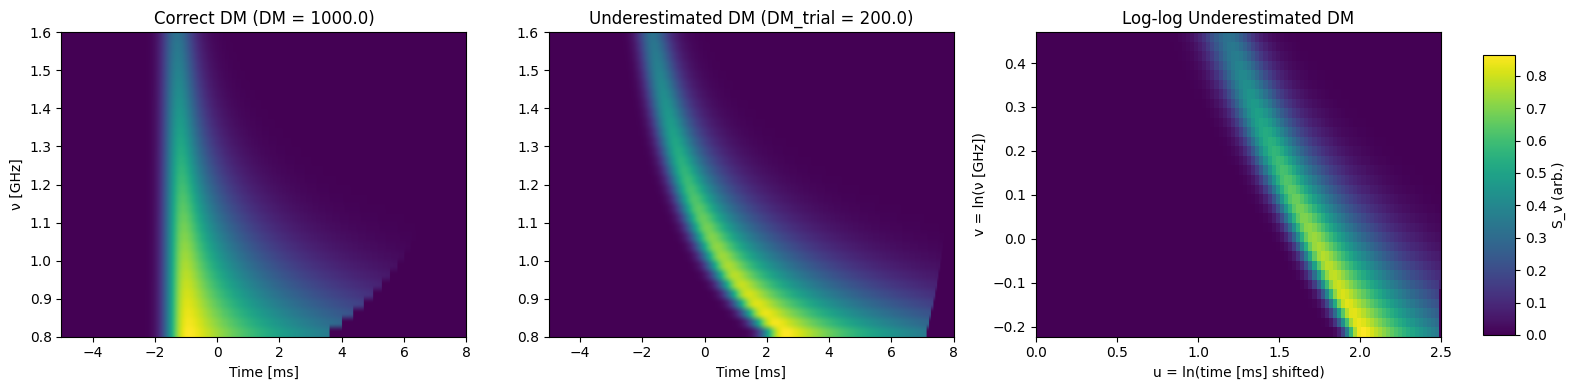

In [4]:
# Plot clean 1x3 layout (no shared y-axis mismatch)
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

extent_lin = [t_min * 1e3, t_max * 1e3, nus[0], nus[-1]]
extent_log = [u.min(), u.max(), v.min(), v.max()]

im0 = axes[0].imshow(dynamic_dedisp_true, aspect="auto", extent=extent_lin, origin="lower")
axes[0].set_title(f"Correct DM (DM = {DM_true})")
axes[0].set_xlabel("Time [ms]")
axes[0].set_ylabel("ν [GHz]")

im1 = axes[1].imshow(dynamic_dedisp_trial, aspect="auto", extent=extent_lin, origin="lower")
axes[1].set_title(f"Underestimated DM (DM_trial = {DM_trial})")
axes[1].set_xlabel("Time [ms]")

im2 = axes[2].imshow(J, aspect="auto", extent=extent_log, origin="lower")
axes[2].set_xlim(0, 2.5)
axes[2].set_title("Log-log Underestimated DM")
axes[2].set_xlabel("u = ln(time [ms] shifted)")
axes[2].set_ylabel("v = ln(ν [GHz])")

# External colorbar
cax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(im2, cax=cax, label="S_ν (arb.)")

plt.tight_layout(rect=[0, 0, 0.92, 1])
plt.show()